# Challenge 1 : Fire mapping - EY
## File to test the model
**Ordronneau Luca - Reberga Louis - Moncoutie Johan - Ettarian Julian**

This notebook describes all the steps to be taken for postprocessing before making a submission.

In [1]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime

from sklearn.utils import shuffle
import cv2

from datacube import Datacube
import matplotlib.pyplot as plt

sys.path.append("../scripts")
from dea_plotting import map_shapefile
from dea_spatialtools import xr_rasterize

import tensorflow as tf
import os
import random

from skimage.io import imread, imshow
from skimage.transform import resize

from numpy import expand_dims

from skimage import data, img_as_float
from skimage import exposure

dc = Datacube(app="Getting started")

seed = 1322

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Test Set
We load our test set

In [2]:
X_test = np.load('X_TEST_413_semi_final.npy')

### Metrics
We add metrics used by our model

In [3]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

from tensorflow.keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

dependencies = {
    'dice_coef': dice_coef,
    'dice_loss': dice_loss,
    'iou_coef' : iou_coef
}

### Model
We load our model

In [5]:
model_name = 'InceptionResNetV2_413_semi_final'
model = tf.keras.models.load_model(str(model_name)+'.h5', custom_objects=dependencies)

### Prediction
We display the normalized predictions (between 0 and 1) of our model 

1/1 [==============================] - 0s 2ms/step


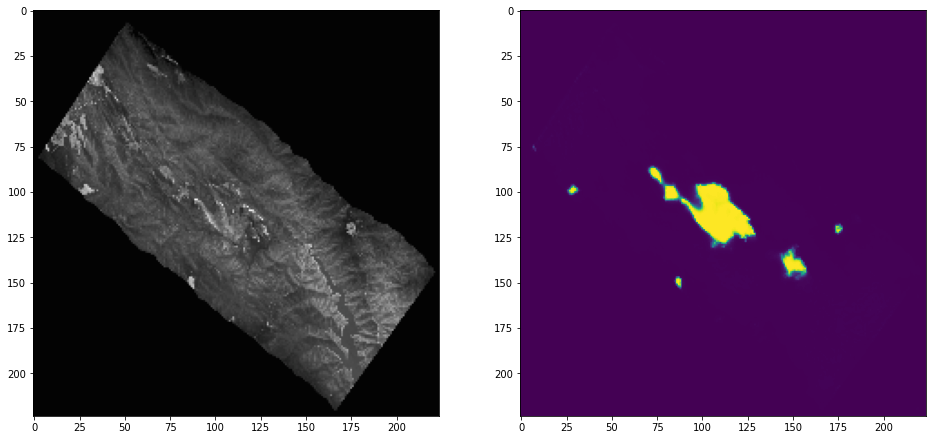

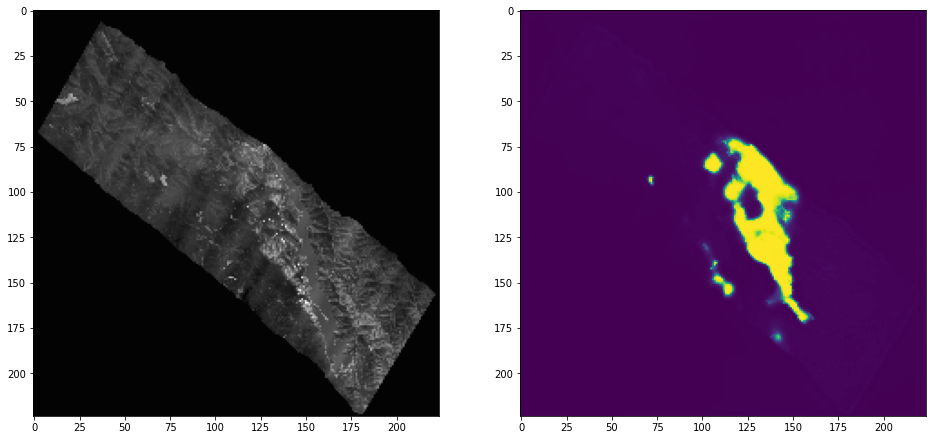

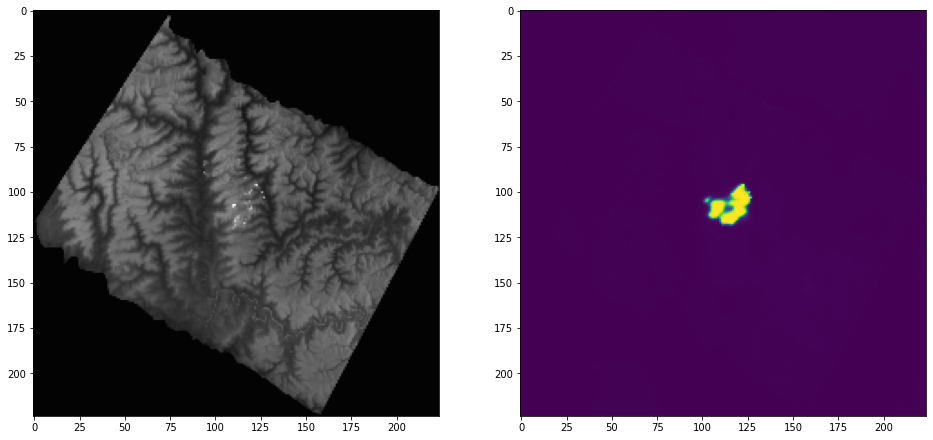

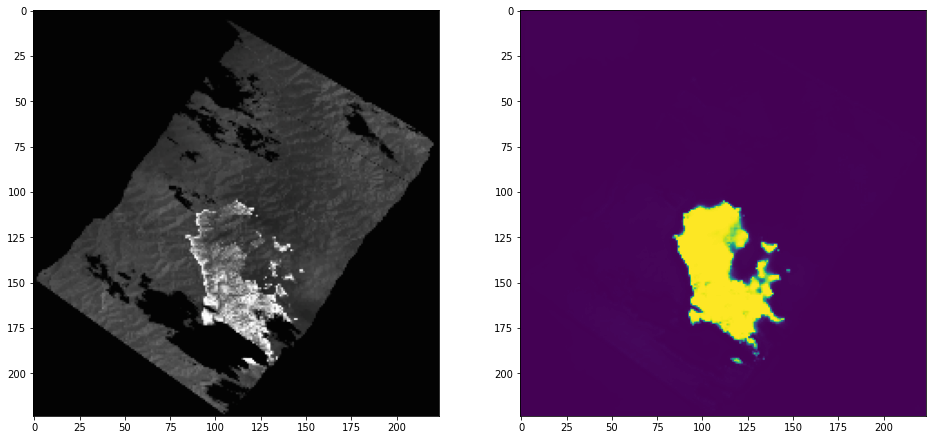

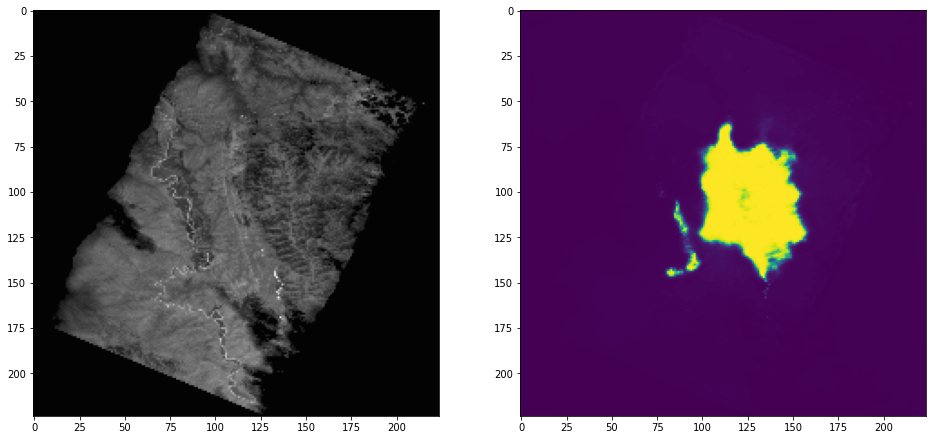

In [6]:
preds = model.predict(X_test, verbose=1)
preds = np.squeeze(preds)

for i in range(len(preds)):
    pred = preds[i]
    f = plt.figure()
    f.set_figheight(16)
    f.set_figwidth(16)
    f.add_subplot(1, 2, 1)
    plt.imshow(X_test[i])
    f.add_subplot(1, 2, 2)
    norm_img = np.zeros((pred.shape[0],pred.shape[1]))
    pred = cv2.normalize(pred,  norm_img, 0, 1, cv2.NORM_MINMAX)
    plt.imshow(pred)
    plt.show(block=True)

Parameters for performing morphological operations on predictions

In [7]:
threshold = 0.1
openK = 3
openI = 1
closeK = 16
closeI = 1
l = 224

We perform **morphological operations** to best fit the predictions

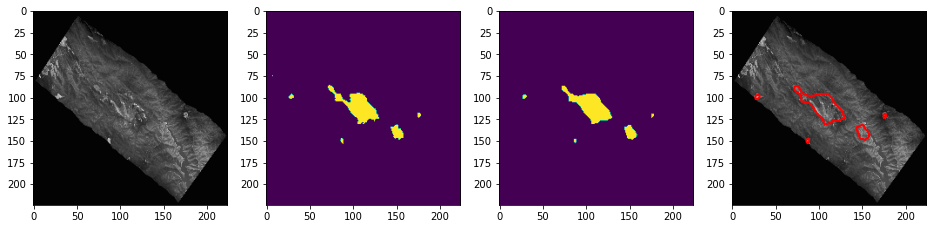

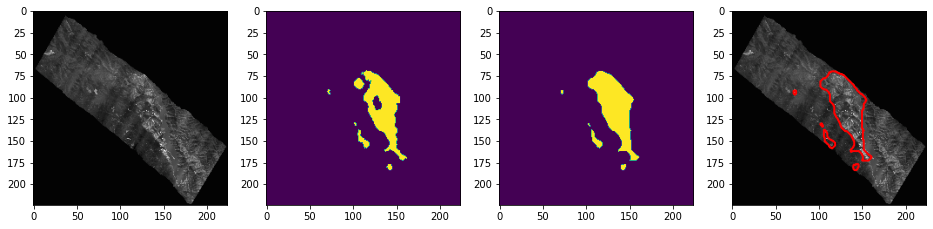

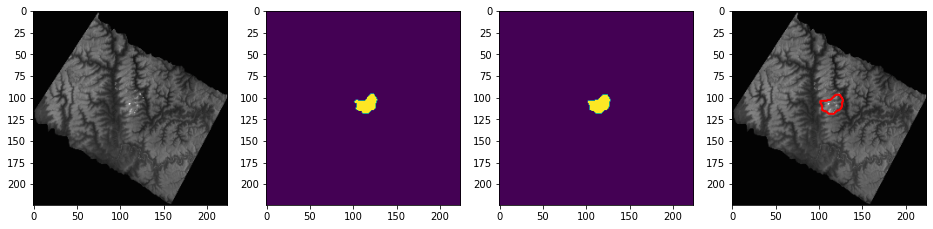

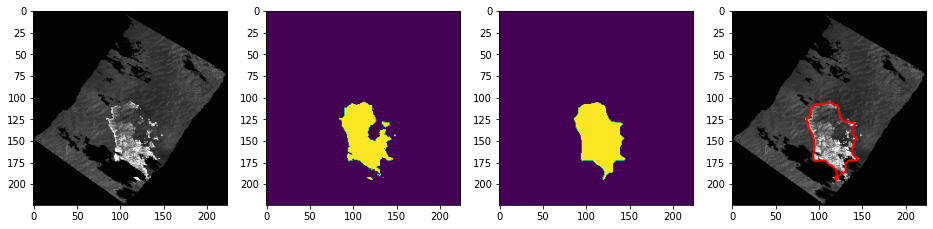

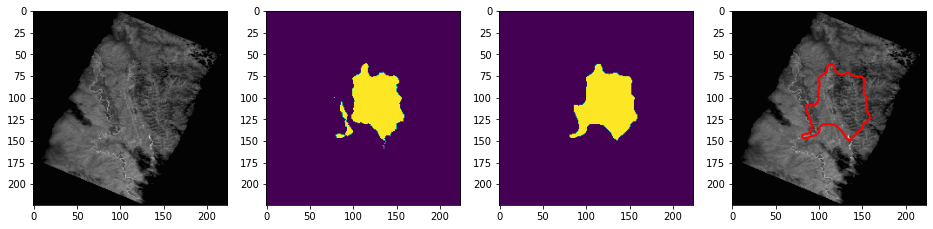

In [8]:
for i in range(preds.shape[0]):
    im = X_test[i]
    pred = preds[i]
    norm_img = np.zeros((pred.shape[0],pred.shape[1]))
    pred = cv2.normalize(pred,  norm_img, 0, 1, cv2.NORM_MINMAX)
    pred = np.where(pred < threshold, 0, 1).astype(np.uint8)
    
    kernelOpen = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(openK,openK))
    kernelClose = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(closeK,closeK))
    pred1 = cv2.morphologyEx(pred,cv2.MORPH_OPEN,kernelOpen, iterations = openI)
    pred2 = cv2.morphologyEx(pred1, cv2.MORPH_CLOSE, kernelClose, iterations = closeI)

    f = plt.figure()
    f.set_figheight(16)
    f.set_figwidth(16)
    f.add_subplot(1, 4, 1)
    plt.imshow(X_test[i])
    f.add_subplot(1, 4, 2)
    plt.imshow(pred)
    f.add_subplot(1, 4, 3)
    plt.imshow(pred2)
    f.add_subplot(1, 4, 4)
    plt.imshow(im[:l, :l])
    plt.contour(pred2[:l, :l], [0.5], linewidths=2, colors='r')
    plt.show(block=True)

After checking the different parameters and the different tests, the same morphological transformations are carried out to obtain the final results of the test set points.

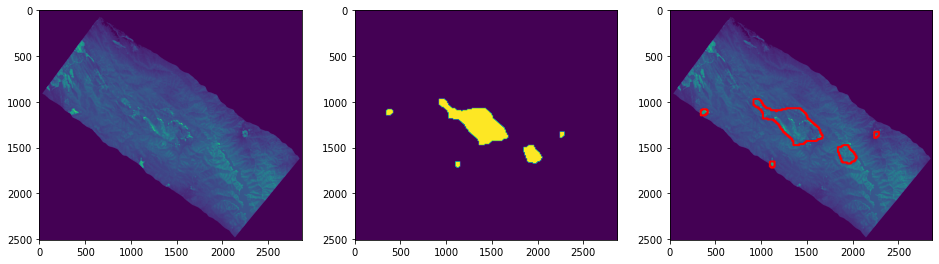

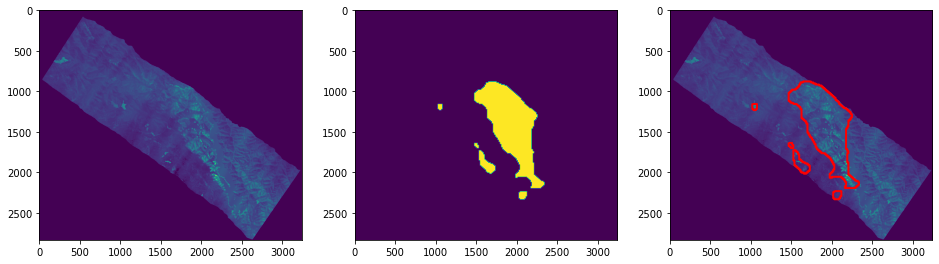

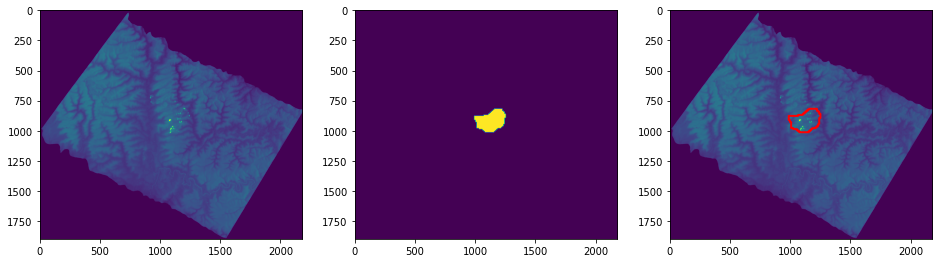

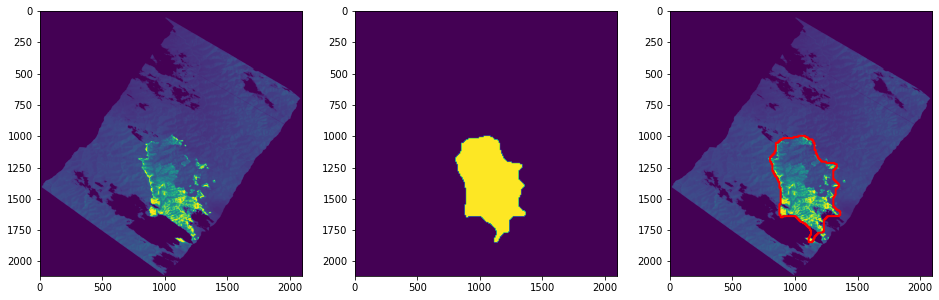

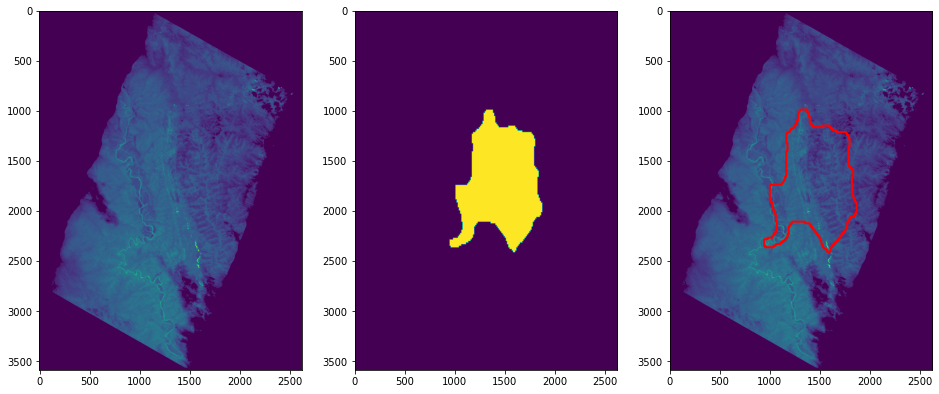

In [9]:
test = pd.read_csv('resources/challenge1_test.csv', index_col='id')
fnames = test.label.unique()
n = 0

for file_stem in fnames:
    
    src = dc.load(product='linescan', label=file_stem, output_crs='epsg:28355', resolution=(-10,10))
    mask = src.linescan   
    shape = mask.values[0].shape
    
    pred = cv2.normalize(preds[n],  norm_img, 0, 1, cv2.NORM_MINMAX)
    pred = np.where(pred < threshold, 0, 1).astype(np.uint8)
    
    kernelOpen = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(openK,openK))
    kernelClose = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(closeK,closeK))
    pred1 = cv2.morphologyEx(pred,cv2.MORPH_OPEN,kernelOpen, iterations = openI)
    pred = cv2.morphologyEx(pred1, cv2.MORPH_CLOSE, kernelClose, iterations = closeI)
    
    pred = resize(pred, shape, mode='constant', preserve_range=True)
    pred = pred.astype('bool')
    
    im = src.linescan.values[0]
    f = plt.figure()
    f.set_figheight(16)
    f.set_figwidth(16)
    f.add_subplot(1, 3, 1)
    plt.imshow(src.linescan.values[0])
    f.add_subplot(1, 3, 2)
    plt.imshow(pred)
    f.add_subplot(1, 3, 3)
    plt.imshow(im[:shape[0], :shape[1]])
    plt.contour(pred[:shape[0], :shape[1]], [0.5], linewidths=2, colors='r')
    plt.show(block=True)
    
    mask.values[0] = pred
    
    for idx, ob in test.loc[test.label==file_stem].iterrows():
        result_tf = mask.sel(x = ob.x, y = ob.y, method='nearest').values[0]
        result_10 = int(result_tf == True)
        test.loc[(test.label==file_stem) & (test.x==ob.x) & (test.y==ob.y), 'target'] = result_10
    
    n += 1

In [10]:
test.target.value_counts()

0.0    3731
1.0    1269
Name: target, dtype: int64

We save our csv for submission

In [11]:
name = model_name + '_open_' + str(openK) + '_iter_' + str(openI) + '_close_' + str(closeK) + '_iter_' + str(closeI) + '_0_1_ellipse.csv'
print(name)
test.to_csv(name, columns = ['target'])

InceptionResNetV2_413_semi_final_open_3_iter_1_close_16_iter_1_0_1_ellipse.csv
